## Model
### 10/08/2024
#### Key refinements:
* Change the epoch from 50 to 100
* Change the learning rate schedule
* Change the units from Dense layers


### Libraries

In [1]:
# Import necessary libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv3D, MaxPooling3D, GlobalAveragePooling3D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

### Frame Generator

In [2]:
def split_data(dataset_dir, val_ratio=0.1):
    '''
    Split the dataset into train, validation, and test sets.
    
    Parameters:
    dataset_dir (str): Path to the dataset directory
    val_ratio (float): Ratio of validation data to be split from training data
    
    Returns:
    dict: Contains file paths, labels, and base directories for train, val, and test sets
    '''
    train_dir = os.path.join(dataset_dir, 'train')
    test_dir = os.path.join(dataset_dir, 'test')
    
    def get_files_and_labels(directory):
        files = []
        labels = []
        for class_label in os.listdir(directory):
            class_dir = os.path.join(directory, class_label)
            for clip in os.listdir(class_dir):
                files.append(os.path.join(class_label, clip))
                labels.append(class_label)
        return files, labels
    
    train_files, train_labels = get_files_and_labels(train_dir)
    test_files, test_labels = get_files_and_labels(test_dir)
    
    # Split training data to create a validation set
    train_files, val_files, train_labels, val_labels = train_test_split(
        train_files, train_labels, 
        test_size=val_ratio, 
        stratify=train_labels, 
        random_state=42
    )
    
    return {
        'train': (train_files, train_labels, train_dir),
        'val': (val_files, val_labels, train_dir),
        'test': (test_files, test_labels, test_dir)
    }

In [3]:
def augment_frame(frame):
    '''
    Augment a single frame using ImageDataGenerator.
    
    Parameters:
    frame (numpy.ndarray): Input frame to be augmented
    
    Returns:
    numpy.ndarray: Augmented frame
    '''
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )
    frame = frame.reshape((1,) + frame.shape)
    aug_frame = next(datagen.flow(frame, batch_size=1))[0]
    return aug_frame

In [4]:
def pad_frames(frames, target_length):
    '''
    Pad or truncate frames to a target length.
    
    Parameters:
    frames (list): List of frames
    target_length (int): Desired length of the frame sequence
    
    Returns:
    list: Padded or truncated list of frames
    '''
    if len(frames) >= target_length:
        return frames[:target_length]
    else:
        padding = [frames[-1]] * (target_length - len(frames))
        return frames + padding

In [5]:
def load_and_preprocess_frames(file_path, max_sequence_length, target_size=(224, 224)):
    '''
    Load and preprocess frames from a directory.
    
    Parameters:
    file_path (str): Path to the directory containing frames
    max_sequence_length (int): Maximum number of frames to process
    target_size (tuple): Target size for frame resizing
    
    Returns:
    numpy.ndarray: Preprocessed frames
    '''
    frames = []
    frame_files = sorted([os.path.join(file_path, f) for f in os.listdir(file_path) if f.endswith(('.jpg', '.png'))])
    #print(f"Number of frame files found: {len(frame_files)}")

    if not frame_files:
        print(f"No frame files found in {file_path}")
        return np.array([])

    sequence_length = min(max_sequence_length, len(frame_files))
    indices = np.linspace(0, len(frame_files) - 1, sequence_length, dtype=int)
    selected_files = [frame_files[i] for i in indices]

    for i, frame_file in enumerate(selected_files):
        frame = cv2.imread(frame_file)
        if frame is None:
            print(f"Error reading frame {i}: {frame_file}")
            continue
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, target_size)
        frame = frame.astype(np.float32) / 255.0
        frame = augment_frame(frame)
        frames.append(frame)

    frames = pad_frames(frames, max_sequence_length)
    frames = np.array(frames)
    frames = np.squeeze(frames)  # Add this line to remove the extra dimension
    # print(f"Successfully loaded and padded to {frames.shape} frames")
    return frames

In [6]:

def frame_generator(split_data, batch_size, sequence_length, target_size=(224, 224), mode='train'):
    '''
    Generator function to yield batches of frames and labels.
    
    Parameters:
    split_data (dict): Contains file paths, labels, and base directories for each set
    batch_size (int): Number of samples per batch
    sequence_length (int): Number of frames per sequence
    target_size (tuple): Target size for frame resizing
    mode (str): 'train', 'val', or 'test'
    
    Yields:
    tuple: Batch of frames and corresponding labels
    '''
    files, labels, base_dir = split_data[mode]
    label_map = {label: idx for idx, label in enumerate(set(labels))}
    
    while True:
        X_batch, y_batch = [], []
        batch_indices = np.random.choice(len(files), size=batch_size, replace=False)
        
        for idx in batch_indices:
            clip_dir = os.path.join(base_dir, files[idx])
            frames = load_and_preprocess_frames(clip_dir, sequence_length, target_size)
            if len(frames) == 0:
                continue
            
            X_batch.append(frames)
            y_batch.append(label_map[labels[idx]])

        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)
        yield X_batch, y_batch

### Model Creation

In [7]:
def create_refined_model(input_shape, num_classes, sequence_length):
    '''
    Create the 3D CNN model.
    
    Parameters:
    input_shape (tuple): Shape of input frames
    num_classes (int): Number of classes for classification
    sequence_length (int): Number of frames in each sequence
    
    Returns:
    tensorflow.keras.Model: Compiled 3D CNN model
    '''
    model = Sequential([
        # 1st block
        Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=(sequence_length, *input_shape)),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),
        
        # 2nd block
        Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),
        
        # 3rd block
        Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),
        
        # 4th block
        Conv3D(256, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling3D((1, 2, 2)),
        
        # 5th block
        Conv3D(256, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        
        # 6th block
        Conv3D(512, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        
        # 7th block
        Conv3D(512, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        
        # 8th block
        Conv3D(512, (3, 3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        
        # Global Average Pooling
        GlobalAveragePooling3D(),
        
        # Dense layers
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(num_classes, activation='softmax')
    ])
    return model

### Parameters

In [8]:
# Model and training parameters
sequence_length = 16
batch_size = 8
input_shape = (224, 224, 3)
epochs = 100

### Learning Rate Schedule

In [9]:
def lr_schedule(epoch):
    '''
    Define learning rate schedule.
    
    Parameters:
    epoch (int): Current epoch number
    
    Returns:
    float: Learning rate for the given epoch
    '''
    initial_lr = 0.0001
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * tf.math.exp(0.05 * (10 - epoch))

# Create optimizer and learning rate scheduler
optimizer = Adam(learning_rate=0.0001)
lr_scheduler = LearningRateScheduler(lr_schedule)

In [10]:
# Prepare data
dataset_dir = 'Extract_Frames_0.5s'
split_data = split_data(dataset_dir)
all_classes = sorted(set(split_data['train'][1] + split_data['test'][1]))
num_classes = len(all_classes)

In [11]:
# Create data generators
train_generator = frame_generator(split_data, batch_size, sequence_length, mode='train')
val_generator = frame_generator(split_data, batch_size, sequence_length, mode='val')
test_generator = frame_generator(split_data, batch_size, sequence_length, mode='test')

In [12]:
# Calculate steps per epoch and validation steps
steps_per_epoch = len(split_data['train'][0]) // batch_size
validation_steps = len(split_data['val'][0]) // batch_size

In [13]:
# Create and compile the model
model = create_refined_model((224, 224, 3), num_classes, sequence_length)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 224, 224, 32)  2624      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 224, 224, 32)  128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 16, 112, 112, 32)  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 16, 112, 112, 64)  55360     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 112, 112, 64)  256       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 16, 56, 56, 128)   2

In [14]:
# Get a sample batch to verify shapes
train_gen = frame_generator(split_data, batch_size, sequence_length, mode='train')
X_sample, y_sample = next(train_gen)
print(f"Sample batch shapes - X: {X_sample.shape}, y: {y_sample.shape}")

Sample batch shapes - X: (8, 16, 224, 224, 3), y: (8,)


### Model training

In [15]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    callbacks=[lr_scheduler, checkpoint, early_stopping, reduce_lr],
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/100
401/401 [==============================] - 297s 741ms/step - loss: 5.2207 - accuracy: 0.0281 - val_loss: 4.6823 - val_accuracy: 0.0199
Epoch 2/100
401/401 [==============================] - 296s 738ms/step - loss: 4.9609 - accuracy: 0.0399 - val_loss: 5.2955 - val_accuracy: 0.0227
Epoch 3/100
401/401 [==============================] - 296s 739ms/step - loss: 4.8035 - accuracy: 0.0365 - val_loss: 4.2499 - val_accuracy: 0.0341
Epoch 4/100
401/401 [==============================] - 297s 742ms/step - loss: 4.6105 - accuracy: 0.0446 - val_loss: 4.9084 - val_accuracy: 0.0653
Epoch 5/100
401/401 [==============================] - 297s 741ms/step - loss: 4.4461 - accuracy: 0.0468 - val_loss: 4.3271 - val_accuracy: 0.0994
Epoch 6/100
401/401 [==============================] - 294s 734ms/step - loss: 4.4169 - accuracy: 0.0499 - val_loss: 4.3070 - val_accuracy: 0.0767
Epoch 7/100
401/401 [==============================] - 296s 739ms/step - loss: 4.3047 - accuracy: 0.0514 - val_loss: 4

In [16]:
# Evaluate the model on test set
test_steps = len(split_data['test'][0]) // batch_size
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

191/191 [==============================] - 107s 561ms/step - loss: 4.1733 - accuracy: 0.1021
Test Loss: 4.173267841339111, Test Accuracy: 0.10209424048662186


## Evaluation

In [17]:
# Generate predictions on the test set
y_true = []
y_pred = []
y_pred_proba = []

for _ in range(test_steps):
    X_batch, y_batch = next(test_generator)
    y_true.extend(y_batch)

    predictions = model.predict(X_batch)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_pred_proba.extend(predictions)

# Convert numeric labels to class names
y_true_str = [all_classes[i] for i in y_true]
y_pred_str = [all_classes[i] for i in y_pred]

# Print classes present in true labels and predictions
# print("Classes present in true labels:", sorted(set(y_true_str)))
# print("Classes present in predictions:", sorted(set(y_pred_str)))

                precision    recall  f1-score   support

    brush_hair       0.00      0.00      0.00        32
     cartwheel       0.06      0.07      0.06        30
         catch       0.27      0.74      0.40        23
          chew       0.21      0.38      0.27        40
          clap       0.12      0.05      0.07        38
         climb       0.00      0.00      0.00        30
  climb_stairs       0.00      0.00      0.00        31
          dive       0.00      0.00      0.00        29
    draw_sword       1.00      0.00      0.00        35
       dribble       0.00      0.00      0.00        42
         drink       0.00      0.00      0.00        26
           eat       0.00      0.00      0.00        32
    fall_floor       0.00      0.00      0.00        27
       fencing       0.00      0.00      0.00        27
     flic_flac       0.00      0.00      0.00        31
          golf       0.07      0.04      0.05        23
     handstand       0.00      0.00      0.00  

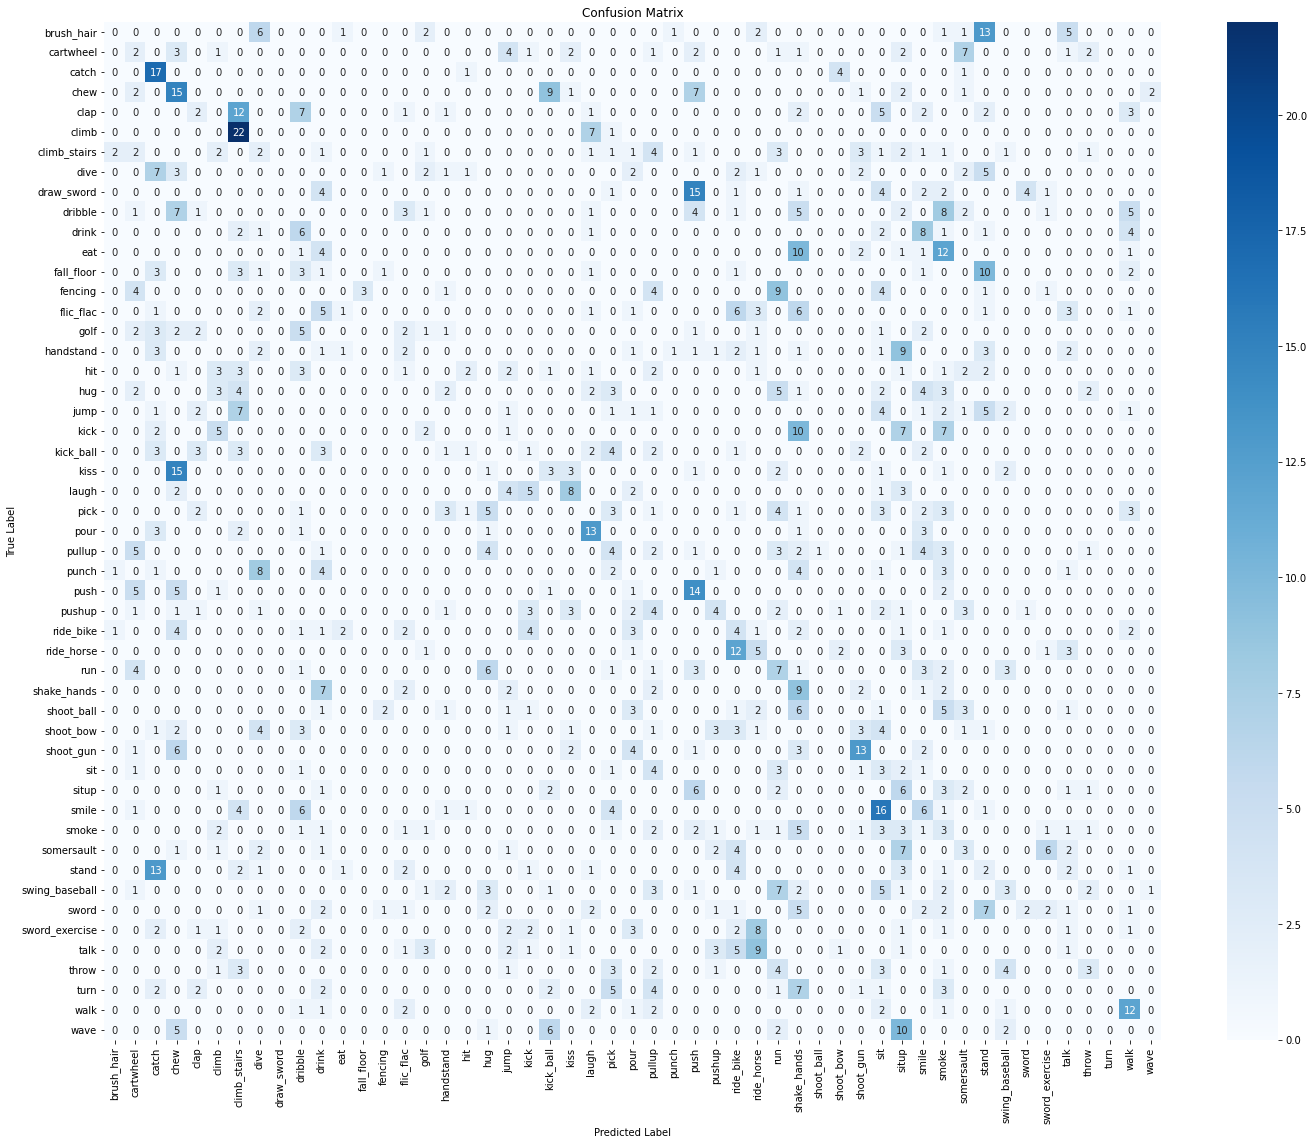

In [18]:
# Generate confusion matrix
cm = confusion_matrix(y_true_str, y_pred_str, labels=all_classes)

# Generate classification report
print(classification_report(y_true_str, y_pred_str, labels=all_classes, zero_division=1))

# Plot confusion matrix
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

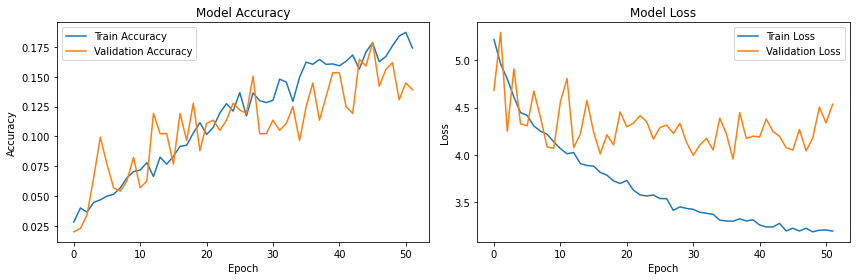

In [19]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()